# Load libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import io
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import BertTokenizerFast, BertForTokenClassification
from transformers import pipeline
import torch


Mounted at /content/drive


### Dialogue G and ACI Bench

#### Load datasets (Dialog G and ACI, long?)

In [ ]:
# Paths to the files
path_acibench_train = '/content/drive/MyDrive/W266_Project/Data/ACIBENCH_train_processed.csv'
path_acibench_val = '/content/drive/MyDrive/W266_Project/Data/ACIBENCH_validation_processed.csv'
path_dialogue_g = '/content/drive/MyDrive/W266_Project/Data/Dialogue G processed.csv'

# Load the datasets
df_dialogue_g = pd.read_csv(path_dialogue_g)
df_acibench_val = pd.read_csv(path_acibench_val)
df_acibench_train = pd.read_csv(path_acibench_train)

# Check the first few rows to ensure they're loaded correctly
print("Dialogue G Dataset:")
print(df_dialogue_g.head())
print("\nACIBENCH Validation Dataset:")
print(df_acibench_val.head())
print("\nACIBENCH Train Dataset:")
print(df_acibench_train.head())


Dialogue G Dataset:
                                            dialogue  \
0  [Doctor]: Good morning, Mr. Abc. I understand ...   
1  [Doctor]: Good morning, Mr. Smith. I understan...   
2  [Doctor]: Good morning, Mr. [Patient], how are...   
3  [Doctor]: Good morning, Mr./Ms. [Patient]. Tha...   
4  [Doctor]: Good morning, Mrs. [Patient], I'm Dr...   

                                                note  
0  SUBJECTIVE \nCHIEF COMPLAINT \nLower back pain...  
1  SUBJECTIVE \nCHIEF COMPLAINT \nBack and leg pa...  
2  SUBJECTIVE\nCHIEF COMPLAINT\nExacerbation of C...  
3  SUBJECTIVE\nCHIEF COMPLAINT\nShortness of brea...  
4  SUBJECTIVE\nCHIEF COMPLAINT\nLeft breast mass....  

ACIBENCH Validation Dataset:
                                            dialogue  \
0  [doctor] alright\n[patient] you're ready just\...   
1  [doctor] alright david so you were just in the...   
2  [doctor] hello .\n[patient_guest] hi .\n[docto...   
3  [doctor] hey diana it's good to see you in her...   
4  

#### Combine Datasets (Dialog G and ACI)

In [ ]:
# Combine all datasets into one dataframe
df_combined = pd.concat([df_dialogue_g, df_acibench_val, df_acibench_train], ignore_index=True)


#### Data Cleaning Combined Dataset (Dialog G and ACI)

In [ ]:
# Step 1: Basic data cleaning
df_combined = df_combined.drop_duplicates()
df_combined = df_combined.dropna()

# Step 2: Remove non-ASCII characters
df_combined['dialogue'] = df_combined['dialogue'].apply(lambda x: x.encode('ascii', errors='ignore').decode('ascii'))
df_combined['note'] = df_combined['note'].apply(lambda x: x.encode('ascii', errors='ignore').decode('ascii'))

# Step 3: Remove brackets and standardize whitespace
def clean_text(text):
    # Remove only the brackets, keep the content inside
    text = re.sub(r'\n', ' ', text)  # This removes all new lines
    text = re.sub(r'\[|\]', '', text)  # This removes all [ and ] characters
    text = re.sub(r'\s+', ' ', text).strip()  # Standardize whitespace
    return text

df_combined['dialogue'] = df_combined['dialogue'].apply(clean_text)
df_combined['note'] = df_combined['note'].apply(clean_text)

# Preview cleaned data
print(df_combined.head(10))


                                            dialogue  \
0  Doctor: Good morning, Mr. Abc. I understand yo...   
1  Doctor: Good morning, Mr. Smith. I understand ...   
2  Doctor: Good morning, Mr. Patient, how are you...   
3  Doctor: Good morning, Mr./Ms. Patient. Thank y...   
4  Doctor: Good morning, Mrs. Patient, I'm Dr. Do...   
5  Doctor: Good morning, Mrs. Patient, thank you ...   
6  Doctor: Good morning, Mrs. Patient. How are yo...   
7  Doctor: Good morning, Mrs. Patient. I understa...   
8  Doctor: Good morning, Mrs. Patient. Thank you ...   
9  Doctor: Good morning, patient. How are you fee...   

                                                note  
0  SUBJECTIVE CHIEF COMPLAINT Lower back pain. HI...  
1  SUBJECTIVE CHIEF COMPLAINT Back and leg pain. ...  
2  SUBJECTIVE CHIEF COMPLAINT Exacerbation of COP...  
3  SUBJECTIVE CHIEF COMPLAINT Shortness of breath...  
4  SUBJECTIVE CHIEF COMPLAINT Left breast mass. H...  
5  SUBJECTIVE CHIEF COMPLAINT Pain and numbness i... 

##### data analysis (ACI and Dialogue)

In [ ]:
# word count for dialogue and dialogue
def word_count(text):
    return len(text.split())

df_combined['Dialogue_Length'] = df_combined['dialogue'].apply(word_count)
df_combined['Note_Length'] = df_combined['note'].apply(word_count)
df_combined.head(2)

,dialogue,note,Dialogue_Length,Note_Length
0,"Doctor: Good morning, Mr. Abc. I understand yo...",SUBJECTIVE CHIEF COMPLAINT Lower back pain. HI...,712,359
1,"Doctor: Good morning, Mr. Smith. I understand ...",SUBJECTIVE CHIEF COMPLAINT Back and leg pain. ...,284,199


In [ ]:
# get the min/ave/max and 90% dialogue and summary length
# diaogue
print("Min dialogue length:", df_combined['Dialogue_Length'].min().astype(int))
print("Ave dialogue length:", df_combined['Dialogue_Length'].mean().astype(int))
print("Max dialogue length:", df_combined['Dialogue_Length'].max().astype(int))
print("95% dialogue length:", df_combined['Dialogue_Length'].quantile(0.95).astype(int))
print("Medican length:", df_combined['Dialogue_Length'].median().astype(int))


# summary
print("Min summary length:", df_combined['Note_Length'].min().astype(int))
print("Ave summary length:", df_combined['Note_Length'].mean().astype(int))
print("Max summary length:", df_combined['Note_Length'].max().astype(int))
print("95% summary length:", df_combined['Note_Length'].quantile(0.95).astype(int))
print("Median summary length:", df_combined['Note_Length'].median().astype(int))

Min dialogue length: 135
Ave dialogue length: 426
Max dialogue length: 3050
95% dialogue length: 966
95% dialogue length: 353
Min summary length: 83
Ave summary length: 276
Max summary length: 752
95% summary length: 458
Median summary length: 257


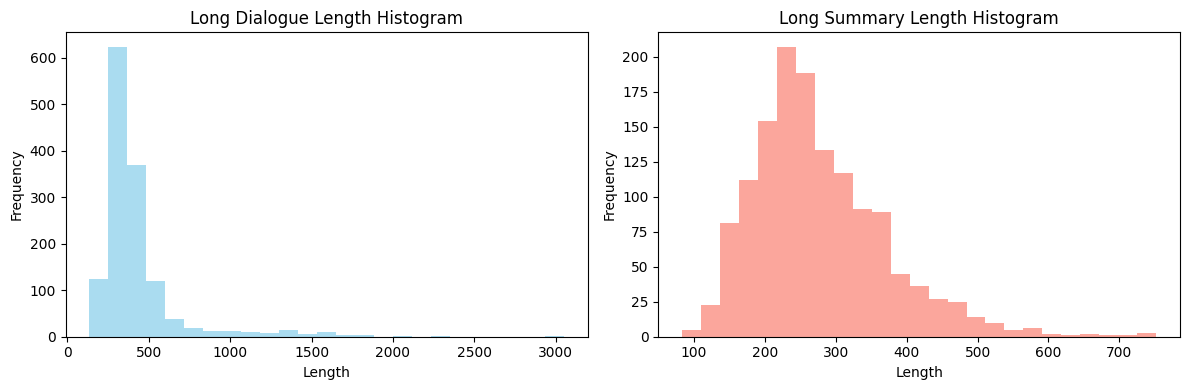

In [ ]:
# plot histgram of dialogue and summary length

# Create a figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot histograms for Dialogue Length and Summary Length
df_combined['Dialogue_Length'].plot(kind='hist', bins=25, color='skyblue', alpha=0.7, ax=axes[0])
axes[0].set_title('Long Dialogue Length Histogram')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Frequency')

df_combined['Note_Length'].plot(kind='hist', bins=25, color='salmon', alpha=0.7, ax=axes[1])
axes[1].set_title('Long Summary Length Histogram')
axes[1].set_xlabel('Length')
axes[1].set_ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

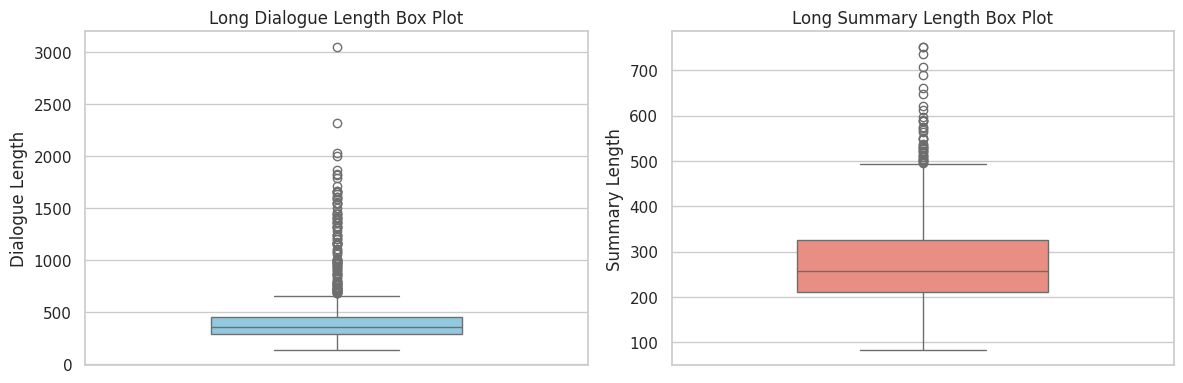

In [ ]:
# Box plot
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot box plots for Dialogue Length and Summary Length with customized appearance
sns.boxplot(y=df_combined['Dialogue_Length'], ax=axes[0], color='skyblue', width=0.5)
axes[0].set_title('Long Dialogue Length Box Plot')
axes[0].set_ylabel('Dialogue Length')

sns.boxplot(y=df_combined['Note_Length'], ax=axes[1], color='salmon', width=0.5)
axes[1].set_title('Long Summary Length Box Plot')
axes[1].set_ylabel('Summary Length')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Data Split
- Train/ validation and test split based on MTS-Dialogue split
- MTS-Dialogue: Train: 1201  Validation: 100, test(2 sets):200
- MTS-Dialogue percentage: **80:7:13**




In [ ]:
# Shuffle the data
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate the size of each subset
train_size = 0.80
val_size = 0.07 / (0.07 + 0.13)

# Split the data
train_df, temp_df = train_test_split(df_combined, train_size=train_size, random_state=42)
val_df, test_df = train_test_split(temp_df, train_size=val_size, random_state=42)

# Specify the directory to save the CSV files
output_dir = '/content/drive/MyDrive/W266_Project/Data'

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Save to CSV
train_df.to_csv(os.path.join(output_dir, 'train_long.csv'), index=False)
val_df.to_csv(os.path.join(output_dir, 'val_long.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'test_long.csv'), index=False)

##### Vervify data split

In [ ]:
# Paths to the files
path_train_long = '/content/drive/MyDrive/W266_Project/Data/train_long.csv'
path_val_long = '/content/drive/MyDrive/W266_Project/Data/val_long.csv'
path_test_long = '/content/drive/MyDrive/W266_Project/Data/test_long.csv'

# Load the datasets
train_long = pd.read_csv(path_train_long)
val_long = pd.read_csv(path_val_long)
test_long = pd.read_csv(path_test_long)

# check the shpae of test/val/test
print("The shape of long dialogue test data is", df_dialogue_g.shape)
print("The shape of long dialogue val data is", df_acibench_val.shape)
print("The shape of long dialogue train data is", df_acibench_train.shape)

# check head of train set
train_long.head(2)


The shape of long dialogue test data is (1291, 2)
The shape of long dialogue val data is (20, 2)
The shape of long dialogue train data is (67, 2)


,dialogue,note,Dialogue_Length,Note_Length
0,"doctor donna torres , date of birth , 08/01/19...",SUBJECTIVE CHIEF COMPLAINT Annual health maint...,1867,471
1,"doctor: Good morning, Mr. patient. I'm Dr. doc...",SUBJECTIVE CHIEF COMPLAINT Patient reports fru...,330,249


### MTS Dataset

#### Load MTS datasets

In [ ]:
# URLs to the MTS-Dialog CSV files on GitHub
url_MTS_train = 'https://raw.githubusercontent.com/abachaa/MTS-Dialog/main/Main-Dataset/MTS-Dialog-TrainingSet.csv'
url_MTS_val = 'https://raw.githubusercontent.com/abachaa/MTS-Dialog/main/Main-Dataset/MTS-Dialog-ValidationSet.csv'
url_MTS_test1 = 'https://raw.githubusercontent.com/abachaa/MTS-Dialog/main/Main-Dataset/MTS-Dialog-TestSet-1-MEDIQA-Chat-2023.csv'
url_MTS_test2 = 'https://raw.githubusercontent.com/abachaa/MTS-Dialog/main/Main-Dataset/MTS-Dialog-TestSet-2-MEDIQA-Sum-2023.csv'

# Load the datasets
df_MTS_train = pd.read_csv(url_MTS_train)
df_MTS_val = pd.read_csv(url_MTS_val)
df_MTS_test1 = pd.read_csv(url_MTS_test1)
df_MTS_test2 = pd.read_csv(url_MTS_test2)

# Check the first few rows to ensure they're loaded correctly
print("MTS Train Dataset:")
print(df_MTS_train.head())
print("\MTS Validation Datsset:")
print(df_MTS_val.head())
print("\nMTS TestSet1:")
print(df_MTS_test1.head())
print("\nMTS TestSet2:")
print(df_MTS_test2.head())


MTS Train Dataset:
   ID section_header                                       section_text  \
0   0          GENHX  The patient is a 76-year-old white female who ...   
1   1          GENHX  The patient is a 25-year-old right-handed Cauc...   
2   2          GENHX  This is a 22-year-old female, who presented to...   
3   3    MEDICATIONS  Prescribed medications were Salmeterol inhaler...   
4   4             CC                                   Burn, right arm.   

                                            dialogue  
0  Doctor: What brings you back into the clinic t...  
1  Doctor: How're you feeling today?  \r\nPatient...  
2  Doctor: Hello, miss. What is the reason for yo...  
3  Doctor: Are you taking any over the counter me...  
4  Doctor: Hi, how are you? \r\nPatient: I burned...  
\MTS Validation Datsset:
   ID section_header                                       section_text  \
0   0          GENHX  The patient is a 26-year-old female, referred ...   
1   1            ROS  As 

#### Combine MTS dataset

In [ ]:
# Combine all MTS datasets into one dataframe
df_MTS_combined = pd.concat([df_MTS_train, df_MTS_val, df_MTS_test1, df_MTS_test2], ignore_index=True)

# Check the combined MTS dataset
print("Combined MTS Dataset:")
print(df_MTS_combined.head())
print("\nTotal number of entries in combined MTS dataset:", len(df_MTS_combined))


Combined MTS Dataset:
   ID section_header                                       section_text  \
0   0          GENHX  The patient is a 76-year-old white female who ...   
1   1          GENHX  The patient is a 25-year-old right-handed Cauc...   
2   2          GENHX  This is a 22-year-old female, who presented to...   
3   3    MEDICATIONS  Prescribed medications were Salmeterol inhaler...   
4   4             CC                                   Burn, right arm.   

                                            dialogue  
0  Doctor: What brings you back into the clinic t...  
1  Doctor: How're you feeling today?  \r\nPatient...  
2  Doctor: Hello, miss. What is the reason for yo...  
3  Doctor: Are you taking any over the counter me...  
4  Doctor: Hi, how are you? \r\nPatient: I burned...  

Total number of entries in combined MTS dataset: 1701


##### Data Analysis (MTS)

In [ ]:
# word count for dialogue and dialogue
df_MTS_combined['Dialogue_Length'] = df_MTS_combined['dialogue'].apply(word_count)
df_MTS_combined['Summary_Length'] = df_MTS_combined['section_text'].apply(word_count)
df_MTS_combined.head(2)

,ID,section_header,section_text,dialogue,Dialogue_Length,Summary_Length
0,0,GENHX,The patient is a 76-year-old white female who ...,Doctor: What brings you back into the clinic t...,110,64
1,1,GENHX,The patient is a 25-year-old right-handed Cauc...,Doctor: How're you feeling today? \r\nPatient...,254,110


In [ ]:
# get the min/ave/max/median and 90% dialogue and summary length
# diaogue
print("Min dialogue length:", df_MTS_combined['Dialogue_Length'].min().astype(int))
print("Ave dialogue length:", df_MTS_combined['Dialogue_Length'].mean().astype(int))
print("Max dialogue length:", df_MTS_combined['Dialogue_Length'].max().astype(int))
print("95% dialogue length:", df_MTS_combined['Dialogue_Length'].quantile(0.95).astype(int))
print("Median dialogue length:", df_MTS_combined['Dialogue_Length'].median().astype(int))

# summary save to integer

print("Min summary length:", df_MTS_combined['Summary_Length'].min().astype(int))
print("Ave summary length:", df_MTS_combined['Summary_Length'].mean().astype(int))
print("Max summary length:", df_MTS_combined['Summary_Length'].max().astype(int))
print("95% summary length:", df_MTS_combined['Summary_Length'].quantile(0.95).astype(int))
print("Median summary length:", df_MTS_combined['Summary_Length'].median().astype(int))

Min dialogue length: 6
Ave dialogue length: 104
Max dialogue length: 1509
95% dialogue length: 327
Median dialogue length: 63
Min summary length: 1
Ave summary length: 39
Max summary length: 1020
95% summary length: 155
Median summary length: 14


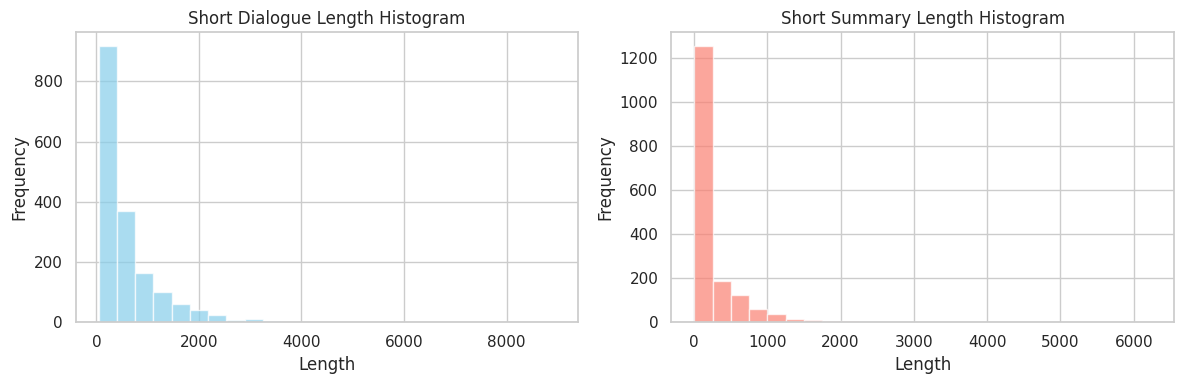

In [ ]:
# plot histgram of dialogue and summary length

# Create a figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot histograms for Dialogue Length and Summary Length
df_MTS_combined['Dialogue_Length'].plot(kind='hist', bins=25, color='skyblue', alpha=0.7, ax=axes[0])
axes[0].set_title('Short Dialogue Length Histogram')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Frequency')

df_MTS_combined['Summary_Length'].plot(kind='hist', bins=25, color='salmon', alpha=0.7, ax=axes[1])
axes[1].set_title('Short Summary Length Histogram')
axes[1].set_xlabel('Length')
axes[1].set_ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

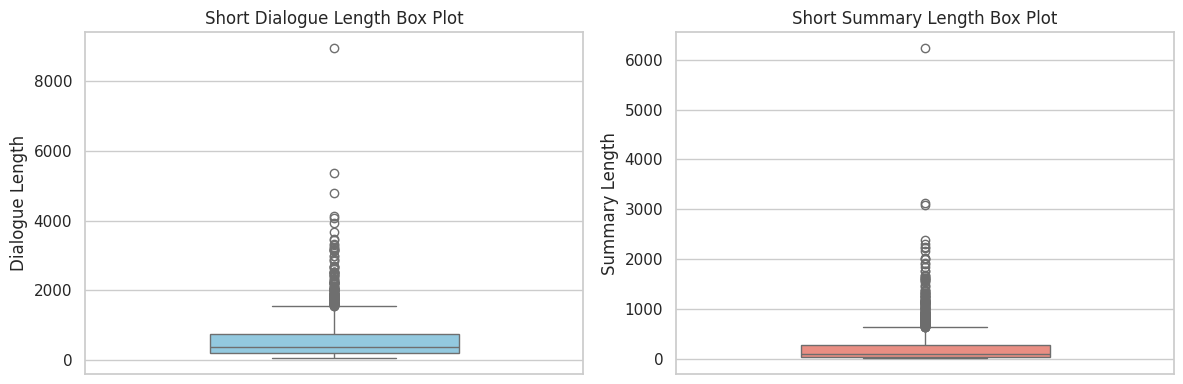

In [ ]:
# Box plot
# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot box plots for Dialogue Length and Summary Length with customized appearance
sns.boxplot(y=df_MTS_combined['Dialogue_Length'], ax=axes[0], color='skyblue', width=0.5)
axes[0].set_title('Short Dialogue Length Box Plot')
axes[0].set_ylabel('Dialogue Length')

sns.boxplot(y=df_MTS_combined['Summary_Length'], ax=axes[1], color='salmon', width=0.5)
axes[1].set_title('Short Summary Length Box Plot')
axes[1].set_ylabel('Summary Length')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Data Clean Combined MTS datatset

In [ ]:
 # Step 1: Drop duplicates
df_MTS_combined = df_MTS_combined.drop_duplicates()

# Step 2: Drop rows with missing values
df_MTS_combined = df_MTS_combined.dropna()

# Step 3: Remove non-ASCII characters and extra whitespace/new lines
def clean_text(text):
    # Remove non-ASCII characters
    text = text.encode('ascii', errors='ignore').decode('ascii')
    # Remove new lines and carriage returns, then standardize whitespace
    text = text.replace('\r', ' ').replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning function to text columns
df_MTS_combined['section_text'] = df_MTS_combined['section_text'].apply(clean_text)
df_MTS_combined['dialogue'] = df_MTS_combined['dialogue'].apply(clean_text)

# Optionally, if 'section_header' also contains text, clean it as well
df_MTS_combined['section_header'] = df_MTS_combined['section_header'].apply(clean_text)

# Preview cleaned data
print(df_MTS_combined.head())


   ID section_header                                       section_text  \
0   0          GENHX  The patient is a 76-year-old white female who ...   
1   1          GENHX  The patient is a 25-year-old right-handed Cauc...   
2   2          GENHX  This is a 22-year-old female, who presented to...   
3   3    MEDICATIONS  Prescribed medications were Salmeterol inhaler...   
4   4             CC                                   Burn, right arm.   

                                            dialogue  Dialogue_Length  \
0  Doctor: What brings you back into the clinic t...              692   
1  Doctor: How're you feeling today? Patient: Ter...             1448   
2  Doctor: Hello, miss. What is the reason for yo...              545   
3  Doctor: Are you taking any over the counter me...              450   
4  Doctor: Hi, how are you? Patient: I burned my ...              145   

   Summary_Length  
0             420  
1             678  
2             268  
3             152  
4         

#### Data split

In [ ]:
# Drop the 'ID' column
df_MTS_combined = df_MTS_combined.drop(columns=['ID'])

# Shuffle the data
df_MTS_combined = df_MTS_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate the size of each subset
train_size = 0.80
val_size = 0.07 / (0.07 + 0.13)

# Split the data
train_df, temp_df = train_test_split(df_MTS_combined, train_size=train_size, random_state=42)
val_df, test_df = train_test_split(temp_df, train_size=val_size, random_state=42)

# Specify the directory to save the CSV files
output_dir = '/content/drive/MyDrive/W266_Project/Data'

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Save to CSV
train_df.to_csv(os.path.join(output_dir, 'train_short.csv'), index=False)
val_df.to_csv(os.path.join(output_dir, 'val_short.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'test_short.csv'), index=False)

##### vervift data split

In [ ]:
# Paths to the files
path_train_short = '/content/drive/MyDrive/W266_Project/Data/train_short.csv'
path_val_short = '/content/drive/MyDrive/W266_Project/Data/val_short.csv'
path_test_short = '/content/drive/MyDrive/W266_Project/Data/test_short.csv'

# Load the datasets
train_short = pd.read_csv(path_train_short)
val_short = pd.read_csv(path_val_short)
test_short = pd.read_csv(path_test_short)

# check the shpae of test/val/test
print("The shape of short dialogue test data is", train_short.shape)
print("The shape of short dialogue val data is", val_short.shape)
print("The shape of short dialogue train data is", test_short.shape)

The shape of short dialogue test data is (1360, 5)
The shape of short dialogue val data is (119, 5)
The shape of short dialogue train data is (222, 5)


In [ ]:
train_short.head(2)

,section_header,section_text,dialogue,Dialogue_Length,Summary_Length
0,GENHX,The patient is a 75-year-old female who comes ...,Doctor: Welcome to the clinic. I am Doctor Fra...,1396,677
1,FAM/SOCHX,Significant for diabetes and hypertension.,Doctor: Does anyone else in your family suffer...,175,42
